<a href="https://colab.research.google.com/github/lohaoxi/basic-pytorch-gans/blob/master/vanilla_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import os
import torch
import torchvision
import numpy as np
from torchvision.datasets import MNIST
import torch.nn as nn
import torch.nn.functional as F
from  torch.utils.data import DataLoader
from matplotlib import pyplot as plt
% matplotlib inline

import math
from torch.autograd import Variable
from torchvision.models import inception_v3
from scipy import linalg


print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not os.path.exists('visuals'):
    os.mkdir('visuals')

1.9.0+cu102
0.10.0+cu102
True


In [2]:
class FlattenTransform:
    def __call__(self, inputs):
        return inputs.view(inputs.shape[0], -1)

In [3]:
BATCH_SIZE = 32
noise_dim = 100

train_data = MNIST('./data/mnist', 
                   train = True,
                   download = True,
                   transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                               FlattenTransform()]))
test_data = MNIST('./data/mnist', 
                  train = False,
                  download = True,
                  transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                              FlattenTransform()]))

train_loader = DataLoader(dataset = train_data,
                          batch_size = BATCH_SIZE,
                          shuffle = True,
                          num_workers = 4)

test_loader = DataLoader(dataset = test_data,
                         batch_size = BATCH_SIZE,
                         shuffle = False,
                         num_workers = 4)


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

In [4]:
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        self.fc_g1 = nn.Linear(in_features = noise_dim, out_features = 1200, bias = True)
        self.fc_g2 = nn.Linear(in_features = 1200, out_features = 1200, bias = True)
        self.fc_g3 = nn.Linear(in_features = 1200, out_features = 1200, bias = True)
        self.fc_g4 = nn.Linear(in_features = 1200, out_features = 784, bias = True)
        self.relu_g1 = nn.ReLU()
        self.relu_g2 = nn.ReLU()
        self.relu_g3 = nn.ReLU()
        self.dropout_g1 = nn.Dropout()
        self.dropout_g2 = nn.Dropout()
        self.dropout_g3 = nn.Dropout()

    def forward(self, src):
        src = src.view(src.size(0), -1)
        src = self.fc_g1(src)
        src=  self.relu_g1(src)
        src = self.dropout_g1(src)
        src = self.fc_g2(src)
        src = self.relu_g2(src)
        src = self.dropout_g2(src)
        src = self.fc_g3(src)
        src = self.relu_g3(src)
        src = self.dropout_g3(src)
        src = self.fc_g4(src)
        return F.sigmoid(src)

class Maxout(nn.Module):
    def __init__(self, n_pieces):
        super(Maxout, self).__init__()
        self.n_pieces = n_pieces

    def forward(self, src):
        # src [batch_size, 625]
        src = src.view(*src.shape[:1], 
                       src.shape[1] // self.n_pieces, 
                       self.n_pieces)
        # src [batch_size, 625 // n_pieces, n_pieces]
        src, _ = src.max(dim = 2)
        return src

class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc_d1 = nn.Linear(in_features = 784, out_features = 625, bias = True)
        self.fc_d2 = nn.Linear(in_features = 125, out_features = 625, bias = True)
        self.fc_d3 = nn.Linear(in_features = 125, out_features = 1, bias = True)
        self.maxout_d1 = Maxout(n_pieces = 5)
        self.maxout_d2 = Maxout(n_pieces = 5)

    def forward(self, src):
        src = src.view(src.size(0), -1)
        src = self.fc_d1(src)
        src = self.maxout_d1(src)
        src = self.fc_d2(src)
        src = self.maxout_d2(src)
        src = self.fc_d3(src)
        return F.sigmoid(src)







In [5]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator_optimizer = torch.optim.SGD(generator.parameters(),
                                      lr = 0.0002,
                                      momentum = 0.5)
discriminator_optimizer = torch.optim.SGD(discriminator.parameters(),
                                          lr = 0.0002,
                                          momentum = 0.5)



criterion = torch.nn.BCELoss()

print(generator)
print(discriminator)

Generator(
  (fc_g1): Linear(in_features=100, out_features=1200, bias=True)
  (fc_g2): Linear(in_features=1200, out_features=1200, bias=True)
  (fc_g3): Linear(in_features=1200, out_features=1200, bias=True)
  (fc_g4): Linear(in_features=1200, out_features=784, bias=True)
  (relu_g1): ReLU()
  (relu_g2): ReLU()
  (relu_g3): ReLU()
  (dropout_g1): Dropout(p=0.5, inplace=False)
  (dropout_g2): Dropout(p=0.5, inplace=False)
  (dropout_g3): Dropout(p=0.5, inplace=False)
)
Discriminator(
  (fc_d1): Linear(in_features=784, out_features=625, bias=True)
  (fc_d2): Linear(in_features=125, out_features=625, bias=True)
  (fc_d3): Linear(in_features=125, out_features=1, bias=True)
  (maxout_d1): Maxout()
  (maxout_d2): Maxout()
)


In [6]:
real_trg = torch.ones(BATCH_SIZE, 1).to(device)
fake_trg = torch.zeros(BATCH_SIZE, 1).to(device)

test_set = torch.randn(16, noise_dim).to(device)


In [7]:
EPOCHS = 512
K = 8
steps = len(train_loader) // BATCH_SIZE
start_time = time.time()

for epoch in range(EPOCHS):

    epoch_DX = 0
    epoch_DGz = 0
    epoch_loss = 0
       
    for i, (src, _) in enumerate(train_loader):
        
        if i == steps: break

        # Train Discriminator

        for _ in range(K):
        
            real_src = src.to(device)

            fake_src = generator(torch.randn(BATCH_SIZE, noise_dim).to(device))

            discriminator_optimizer.zero_grad()

            real_outputs = discriminator(real_src)
            fake_outputs = discriminator(fake_src)

            DX = criterion(real_outputs, real_trg)
            DGz = criterion(fake_outputs, fake_trg)

            DX.backward()
            DGz.backward()

            discriminator_optimizer.step()

            epoch_DX += DX
            epoch_DGz += DGz

        # Train Generator
        z = torch.randn(BATCH_SIZE, noise_dim).to(device)

        generator.zero_grad()

        outputs = discriminator(generator(z))

        loss = criterion(outputs, real_trg)

        loss.backward()

        generator_optimizer.step()
        
        epoch_loss += loss        
    
    print("Epoch: {:04}, DX: {:0.4f}, DGz: {:0.4f}, Loss: {:0.4f}, Elapsed Time: {:0.6f}".format(epoch + 1, 
                                                                                                 epoch_DX / steps / 8,
                                                                                                 epoch_DGz / steps / 8,
                                                                                                 epoch_loss / steps, 
                                                                                                 time.time() - start_time))
    if epoch % 10 == 0:

        generated = generator(test_set).detach().cpu().view(-1, 1, 28, 28)

        grid = torchvision.utils.save_image(generated, 
                                            os.path.join('visuals', '{}.jpg'.format(str(epoch).zfill(6))),
                                            nrow = 4,
                                            padding = 10,
                                            pad_value = 1)
                                                                                       


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0001, DX: 0.6996, DGz: 0.4164, Loss: 1.1247, Elapsed Time: 2.097353
Epoch: 0002, DX: 0.5856, DGz: 0.1913, Loss: 1.7687, Elapsed Time: 4.042831
Epoch: 0003, DX: 0.3961, DGz: 0.1085, Loss: 2.2920, Elapsed Time: 5.968318
Epoch: 0004, DX: 0.2413, DGz: 0.0640, Loss: 2.7976, Elapsed Time: 7.860393
Epoch: 0005, DX: 0.1510, DGz: 0.0396, Loss: 3.2628, Elapsed Time: 9.778019
Epoch: 0006, DX: 0.1008, DGz: 0.0261, Loss: 3.6670, Elapsed Time: 11.681381
Epoch: 0007, DX: 0.0701, DGz: 0.0185, Loss: 4.0065, Elapsed Time: 13.583945
Epoch: 0008, DX: 0.0554, DGz: 0.0139, Loss: 4.2904, Elapsed Time: 15.513219
Epoch: 0009, DX: 0.0438, DGz: 0.0109, Loss: 4.5280, Elapsed Time: 17.418482
Epoch: 0010, DX: 0.0341, DGz: 0.0088, Loss: 4.7377, Elapsed Time: 19.356705
Epoch: 0011, DX: 0.0283, DGz: 0.0074, Loss: 4.9187, Elapsed Time: 21.262227
Epoch: 0012, DX: 0.0244, DGz: 0.0063, Loss: 5.0786, Elapsed Time: 23.173882
Epoch: 0013, DX: 0.0212, DGz: 0.0054, Loss: 5.2201, Elapsed Time: 25.071598
Epoch: 0014, DX: 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


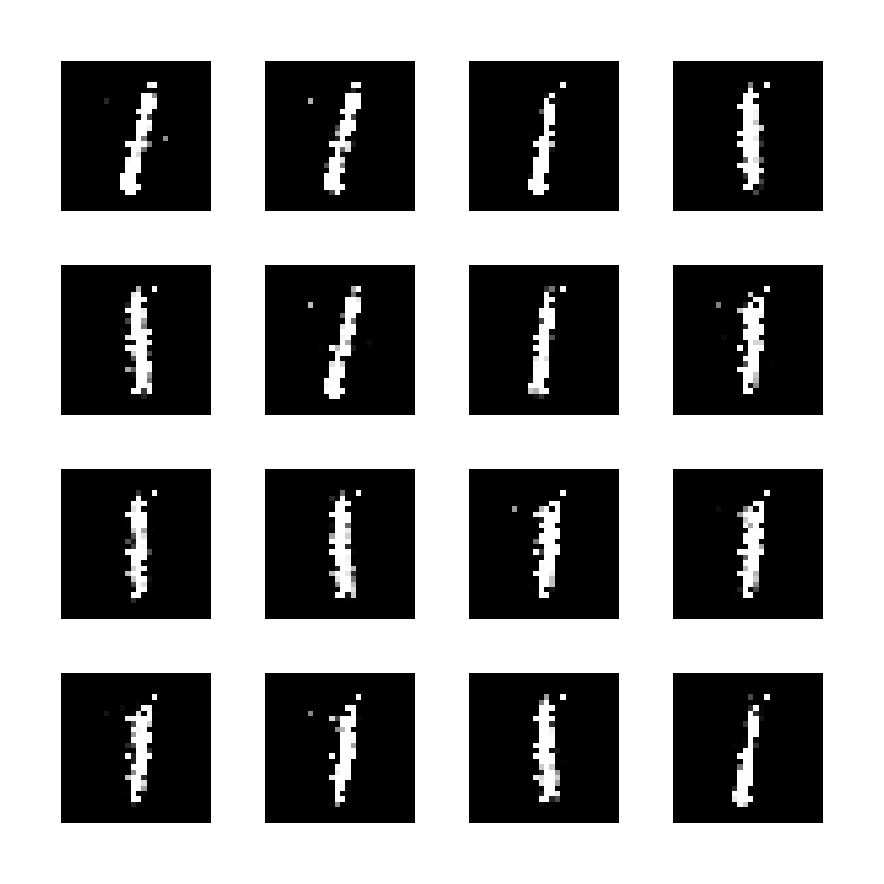

In [8]:
generated = generator(test_set).detach().cpu().view(-1, 1, 28, 28)

grid = torchvision.utils.make_grid(generated,
                                   nrow = 4,
                                   padding = 10,
                                   pad_value = 1)

img = np.transpose(grid.numpy(), (1, 2, 0))

fig = plt.figure(figsize = (16, 16))
plt.axis("off")
plt.imshow(img);

In [9]:
# inception score
inception_net = inception_v3(pretrained = True).to(device)

def inception_score(outputs, batch_size, net):

    scores = []

    # number of outputs
    n = int(math.ceil(float(len(outputs)) / float(batch_size)))

    # iterate over the output
    for i in range(n):

        output = outputs[(i*batch_size):((i+1)*batch_size)]
        output = Variable(output)

        '''
        The first output is a linear layer at the end of the network.
        The second output is known as an auxiliary output and is contained in the AuxLogits part of the network.
        '''
        score, _ = net(output)
        scores.append(score)

    scores = torch.cat(scores, 0)

    '''
    IS(x) = E[ KL( P(y|x) || P(y)) ]
    x: generated images
    y: inception model classification distribution aka softmax
    '''
    # calculate p(y|x) across dimension 1
    p_yx = F.softmax(scores, 1)

    # calculate p(y) across dimension 0
    p_y = p_yx.mean(0)
    p_y = p_y.unsqueeze(0)
    p_y = p_y.expand(p_yx.size(0), -1)

    # calculate KL divergence
    KL_d = p_yx * (torch.log(p_yx) - torch.log(p_y))

    # calculate mean aka expected of KL
    IS = KL_d.mean().item()

    return IS

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


In [10]:
# calculate inception score
outputs = generator(test_set)
# reshape to 1x28x28
outputs = outputs.view(-1, 1, 28, 28)
# repeat Gray channel to RGB
outputs = outputs.repeat(1, 3, 1, 1)
# resize the images to 3x299x299
outputs = F.interpolate(outputs, size=(299, 299))
# calculate inception score
score = inception_score(outputs, BATCH_SIZE, inception_net)
print(score)

0.0005619550938718021


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [11]:
# FID score

# inception v3 feature extractor
class PartialInceptionNetwork(torch.nn.Module):
  
  def __init__(self):
      # trigger parent constructor
      super(PartialInceptionNetwork, self).__init__()
      # initialize pretrained network
      self.inception_network = inception_v3(pretrained=True)
      # register a forward hook otherwise not implemented exception is raised
      self.inception_network.Mixed_7c.register_forward_hook(self.output_hook)

  # register hook to allow forward pass on second to last block
  def output_hook(self, module, input, output):
      self.mixed_7c_output = output # [N, 2048, 8, 8]

  def forward(self, x):
      """
      Args: x: shape (N, 3, 299, 299) dtype: torch.float32 in range 0-1
      Returns: inception activations: torch.tensor, shape: (N, 2048), dtype: torch.float32
      """
      # Trigger output hook
      self.inception_network(x)
      activations = self.mixed_7c_output # [N, 2048, 8, 8]
      activations = torch.nn.functional.adaptive_avg_pool2d(activations, (1, 1)) # [N, 2048, 1, 1]
      activations = activations.view(x.shape[0], 2048)
      return activations


# initialize pretrained inception network
partial_inception_net = PartialInceptionNetwork().to(device)


def fid_score(real_outputs, fake_outputs, batch_size, net):

    real_activations = []
    fake_activations = []
    n = int(math.ceil(float(len(real_outputs)) / float(batch_size)))

    for i in range(n):

        real_output = real_outputs[(i*batch_size):((i+1)*batch_size)]
        fake_output = fake_outputs[(i*batch_size):((i+1)*batch_size)]
        
        real_output = Variable(real_output)
        fake_output = Variable(fake_output)

        real_features = net(real_output)
        fake_features = net(fake_output)

        real_activations.append(real_features)
        fake_activations.append(fake_features)

    real_features = torch.cat(real_activations, 0)
    fake_features = torch.cat(fake_activations, 0)

    x_real = real_features.detach().cpu().numpy()
    x_fake = fake_features.detach().cpu().numpy()

    # calculate mean
    u_real = np.mean(x_real, axis = 0)
    u_fake = np.mean(x_fake, axis = 0)

    # calculate variance
    s_real = np.cov(x_real, rowvar = False)
    s_fake = np.cov(x_fake, rowvar = False)

    # difference squared
    diff = u_real - u_fake
    diff_squared = diff.dot(diff)

    # trace covariance product
    prod = s_real.dot(s_fake)
    sqrt_prod, _ = linalg.sqrtm(prod, disp=False)
    
    # avoid imaginary numbers
    if np.iscomplexobj(sqrt_prod):
        sqrt_prod = sqrt_prod.real

    prod_tr = np.trace(sqrt_prod)

    # calculate FID
    FID = diff_squared + np.trace(s_real) + np.trace(s_fake) - 2 * prod_tr

    return FID

In [12]:
# calculate FID score

real_outputs, _ = next(iter(train_loader))
real_outputs = real_outputs.to(device)
real_outputs = real_outputs.view(-1, 1, 28, 28)
real_outputs = real_outputs.repeat(1, 3, 1, 1)
real_outputs = F.interpolate(real_outputs, size=(299, 299))

fake_outputs = generator(test_set)
fake_outputs = fake_outputs.view(-1, 1, 28, 28)
fake_outputs = fake_outputs.repeat(1, 3, 1, 1)
fake_outputs = F.interpolate(fake_outputs, size=(299, 299))

score = fid_score(real_outputs, fake_outputs, BATCH_SIZE, partial_inception_net)
print(score)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


135.69471714515737
